---
### Sentiment Analysis with Python
---

Date: June 2021

Goal: Build a model that will accuratly predict the sentiment of user reviews.
Build data: clothing reviews in the 'womens_clothing_review.csv' file.
Method: Use of NLP and deep learning methods to achieve the goal. 

---
#### Libraries
---

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, re, string, nltk, tensorflow as tf
from string import punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
#### Functions
---

In [2]:
# Text preprocessing
def get_text(text):
    stop = stopwords.words('english')
    no_punct = [char for char in text if char not in string.punctuation]
    no_punct = ''.join(no_punct)
    
    return ' '.join([word for word in no_punct.split() if word.lower() not in stop])


---
#### Data Preparation
---

Polarity rules:
* If the existing rating > 3 then polarity_rating = “Positive”
* If the existing rating == 3 then polarity_rating = “Neutral”
* If the existing rating < 3 then polarity_rating = “Negative”

In [3]:
# Load data
df = pd.read_csv('women_clothing_review.csv')
# Drop unusful data
df = df.drop(['Title', 'Positive Feedback Count', 'Unnamed: 0'], axis = 1)
df.dropna(inplace = True)

# Calculate Polarity
df['Polarity Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3 else 'Negative'))
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity Rating
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,Neutral
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive


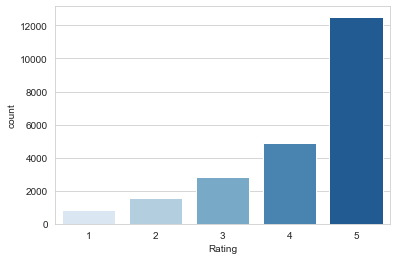

In [4]:
# Visualise rating distribution
sns.set_style('whitegrid')
sns.countplot(x = 'Rating', data = df, palette = 'Blues');

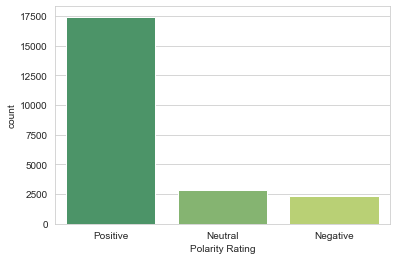

In [5]:
# Visualise the polarity distribution
sns.set_style('whitegrid')
sns.countplot(x = 'Polarity Rating', data = df, palette = 'summer');

---
#### Data Preprocessing
---

In [6]:
df_pos = df[df['Polarity Rating'] == 'Positive'][0:8000]
df_neu = df[df['Polarity Rating'] == 'Neutral']
df_neg = df[df['Polarity Rating'] == 'Negative']

# Sample neutral & negative and create final df
df_neg_o = df_neg.sample(8000, replace = True)
df_neu_o = df_neu.sample(8000, replace = True)
df = pd.concat([df_pos, df_neg_o, df_neu_o], axis = 0)

df['Review'] = df['Review Text'].apply(get_text)
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity Rating,Review
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive,Absolutely wonderful silky sexy comfortable
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive,Love dress sooo pretty happened find store im ...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive,shirt flattering due adjustable front tie perf...
6,858,39,I aded this in my basket at hte last mintue to...,5,1,General Petite,Tops,Knits,Positive,aded basket hte last mintue see would look lik...


In [7]:
# Review text with rating
df = df[['Review', 'Polarity Rating']]
df.head()

,Review,Polarity Rating
0,Absolutely wonderful silky sexy comfortable,Positive
1,Love dress sooo pretty happened find store im ...,Positive
3,love love love jumpsuit fun flirty fabulous ev...,Positive
4,shirt flattering due adjustable front tie perf...,Positive
6,aded basket hte last mintue see would look lik...,Positive


In [8]:
# Apply One Hot Encoding to pos / neu / neg
one_hot = pd.get_dummies(df['Polarity Rating'])
df.drop(['Polarity Rating'], axis = 1, inplace = True)
df = pd.concat([df, one_hot], axis = 1)
df.head()

,Review,Negative,Neutral,Positive
0,Absolutely wonderful silky sexy comfortable,0,0,1
1,Love dress sooo pretty happened find store im ...,0,0,1
3,love love love jumpsuit fun flirty fabulous ev...,0,0,1
4,shirt flattering due adjustable front tie perf...,0,0,1
6,aded basket hte last mintue see would look lik...,0,0,1


---
#### Deep Learning Model
---

In [9]:
# Train / Test split
x = df['Review'].values
y = df.drop('Review', axis = 1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Vectorisation
vect = CountVectorizer()
x_train = vect.fit_transform(x_train)
x_test = vect.transform(x_test)

# Frequency / invert document frequency
TF_ID = TfidfTransformer()
x_train = TF_ID.fit_transform(x_train)
x_train = x_train.toarray()

x_test = TF_ID.fit_transform(x_test)
x_test = x_test.toarray()

# Build Sequential Neural Network
model = Sequential()

model.add(Dense(units = 12673, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 4000, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 3, activation = 'softmax'))

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [10]:
# Fit the model
model.fit(x = x_train, y = y_train, batch_size = 256, epochs = 10, validation_data = (x_test, y_test), verbose = 1, callbacks = early_stop)

Epoch 1/10
66/66 [==============================] - 139s 2s/step - loss: 0.6036 - accuracy: 0.7351 - val_loss: 0.3333 - val_accuracy: 0.8799
Epoch 2/10
66/66 [==============================] - 136s 2s/step - loss: 0.1137 - accuracy: 0.9626 - val_loss: 0.2440 - val_accuracy: 0.9242
Epoch 3/10
66/66 [==============================] - 134s 2s/step - loss: 0.0240 - accuracy: 0.9937 - val_loss: 0.2787 - val_accuracy: 0.9253
Epoch 4/10
66/66 [==============================] - 136s 2s/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.3360 - val_accuracy: 0.9292
Epoch 00004: early stopping


In [11]:
# Evaluate model
model_score = model.evaluate(x_test, y_test, batch_size = 64, verbose = 1)
print('Test Accuracy: ', round(100 * model_score[1],1),'%')

# Prediction 
pred = model.predict(x_test).round(0)

# Summary data
test_df = pd.DataFrame(y_test)
pred_df = pd.DataFrame(pred)

test_total = test_df[0].sum() + test_df[1].sum() + test_df[2].sum()
pred_total = pred_df[0].sum() + pred_df[1].sum() + pred_df[2].sum()

pct_neg = np.abs((pred_df[0].sum() - test_df[0].sum()) / test_df[0].sum())
pct_neu = np.abs((pred_df[1].sum() - test_df[1].sum()) / test_df[1].sum())
pct_pos = np.abs((pred_df[2].sum() - test_df[2].sum()) / test_df[2].sum())
pct_total = np.abs((pred_total - test_total) / test_total)

plot_df = {'Negative':[test_df[0].sum().round(), pred_df[0].sum().round(), round(100 * (1 - pct_neg),2)], 
            'Neutral':[test_df[1].sum().round(), pred_df[1].sum().round(), round(100 * (1 - pct_neu),2)],
            'Positive':[test_df[2].sum().round(), pred_df[2].sum().round(), round(100 * (1 - pct_pos),2)],
            'Total':[test_total.round(), pred_total.round(), round(100 * (1 - pct_total),2)]}

fdf = pd.DataFrame(plot_df)
fdf.index = ['Test total', 'Prediction total', '% Accuracy']
fdf

113/113 [==============================] - 22s 192ms/step - loss: 0.3360 - accuracy: 0.9292
Test Accuracy:  92.9 %


,Negative,Neutral,Positive,Total
Test total,2405.00,2436.0,2359.00,7200.00
Prediction total,2444.00,2419.0,2320.00,7183.00
% Accuracy,98.38,99.3,98.35,99.76


---
Closing
---

In this example we have taken the raw review data and using a combined NLP and neural network approach developed a model which;
* Takes the raw data file, processes and cleanses it for analysis. 
* Creates a polarity measure for model training and testing of review sentiments. 
* Predicts the labels of the test data with an accuracy over 92%. 
* Globally has an accuracy of over;
    * 98% for positive reviews
    * 99% for neutral reviews
    * 98% for negative reviews 